In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import skimage


import warnings
warnings.filterwarnings('ignore')


In [2]:
import os

repo_name = 'Cereal_plant_disease_classification_with_severity_scoring_and_treatment_recommendation'
repo_url = f'https://github.com/daivik05/{repo_name}'
!git clone $repo_url
project_dir = f'/content/{repo_name}'
%cd $project_dir

train_path = 'train/'
categories = os.listdir(train_path)
print(f'The Number Of categories are : {len(categories)} Category')

Cloning into 'Cereal_plant_disease_classification_with_severity_scoring_and_treatment_recommendation'...
remote: Enumerating objects: 4751, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 4751 (delta 2), reused 0 (delta 0), pack-reused 4742
Receiving objects: 100% (4751/4751), 1.61 GiB | 32.02 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Updating files: 100% (4723/4723), done.
/content/Cereal_plant_disease_classification_with_severity_scoring_and_treatment_recommendation
The Number Of categories are : 10 Category


In [4]:
cat_freq = {}
for cat in categories:
    cat_freq[cat] = len(os.listdir(train_path + cat))

# Create A dataframe
cat_freq_df = pd.DataFrame.from_dict(cat_freq, orient='index', columns=['Frequencies'])

# Rename the index column to "Categories"
cat_freq_df.reset_index(inplace=True)
cat_freq_df.columns = ['Categories', 'Frequencies']
cat_freq_df

,Categories,Frequencies
0,wheat_leaf_septoria,97
1,wheat_leaf_Healthy,102
2,wheat_leaf_stripe_rust,208
3,rice_Leaf smut,40
4,corn_Common_Rust,1306
5,corn_Gray_Leaf_Spot,574
6,corn_Blight,1146
7,rice_Brown spot,40
8,corn_Healthy,1162
9,rice_Bacterial leaf blight,40


In [5]:
cat_freq_df.describe()

,Frequencies
count,10.000000
mean,471.500000
std,531.604124
min,40.000000
25%,54.250000
50%,155.000000
75%,1003.000000
max,1306.000000


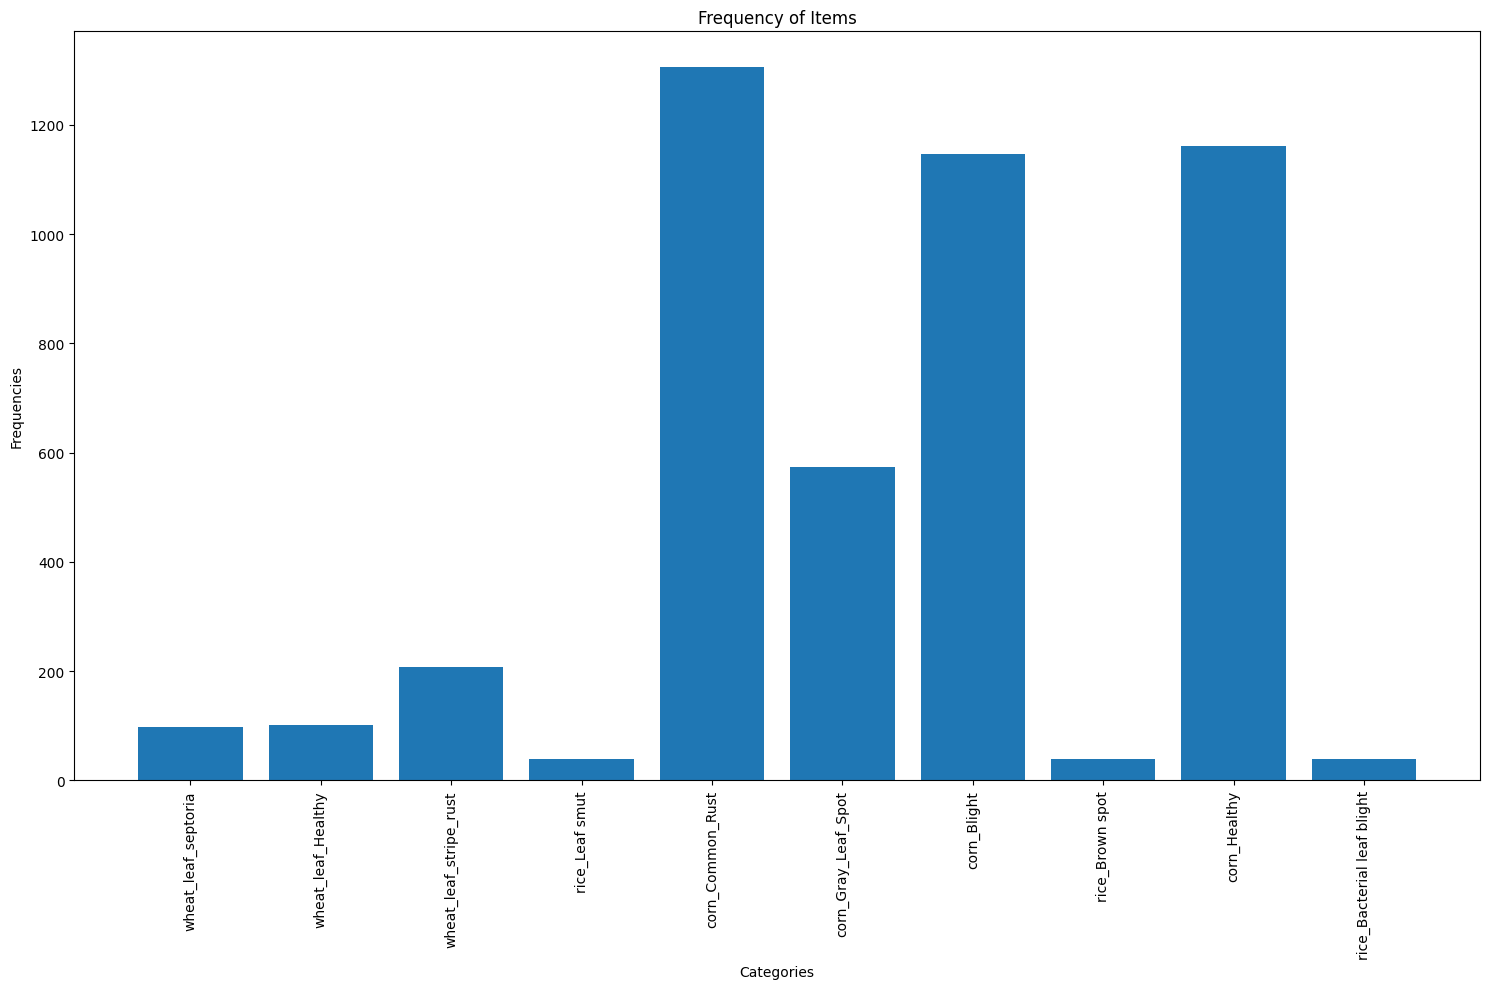

In [6]:
plt.figure(figsize=(15, 10))
plt.bar(cat_freq_df['Categories'], cat_freq_df['Frequencies'])
plt.xlabel('Categories')
plt.ylabel('Frequencies')
plt.title('Frequency of Items')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [7]:
fruits_veg = []
for cat in categories:
    fruits_veg.append(cat.split('___')[0])
unique_fruites_veg = list(np.unique(fruits_veg))

# Print the number of fruits and vegetables detected
print(f'The represents {len(unique_fruites_veg)} Different types of Fruits and Vegetables as follows : ')
unique_fruites_veg

The represents 10 Different types of Fruits and Vegetables as follows : 


['corn_Blight',
 'corn_Common_Rust',
 'corn_Gray_Leaf_Spot',
 'corn_Healthy',
 'rice_Bacterial leaf blight',
 'rice_Brown spot',
 'rice_Leaf smut',
 'wheat_leaf_Healthy',
 'wheat_leaf_septoria',
 'wheat_leaf_stripe_rust']

In [8]:
veg_fruite_cat = {}
for i in unique_fruites_veg:
    num = 0
    for j in categories:
        if i in j:
            num +=1
    veg_fruite_cat[i] = num
veg_fruite_cat

{'corn_Blight': 1,
 'corn_Common_Rust': 1,
 'corn_Gray_Leaf_Spot': 1,
 'corn_Healthy': 1,
 'rice_Bacterial leaf blight': 1,
 'rice_Brown spot': 1,
 'rice_Leaf smut': 1,
 'wheat_leaf_Healthy': 1,
 'wheat_leaf_septoria': 1,
 'wheat_leaf_stripe_rust': 1}

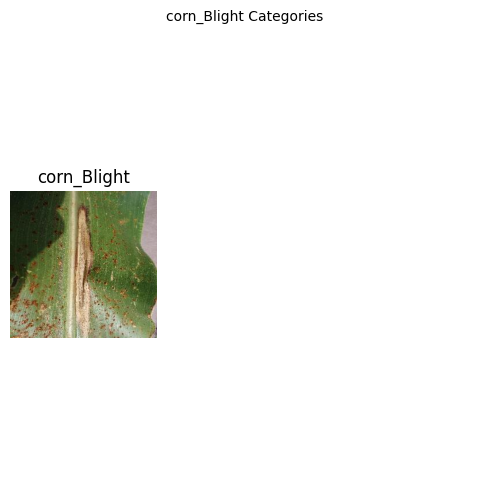

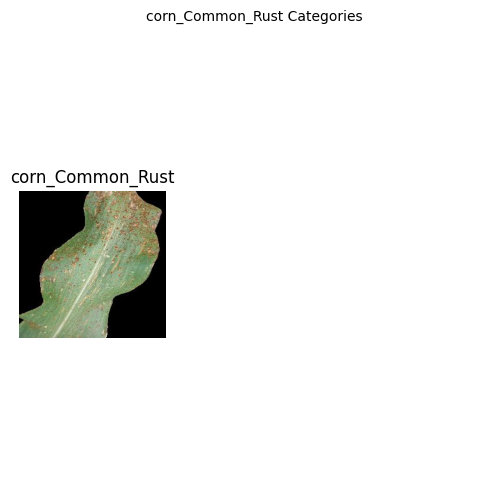

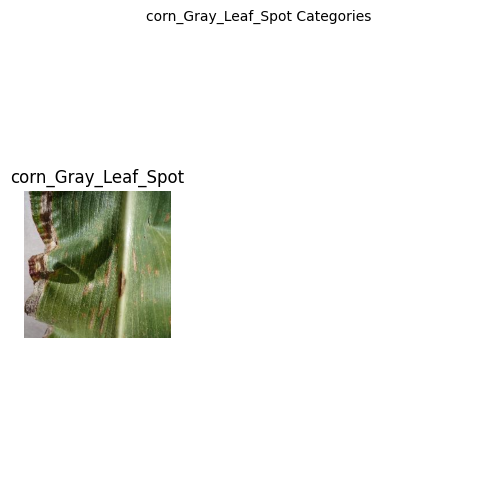

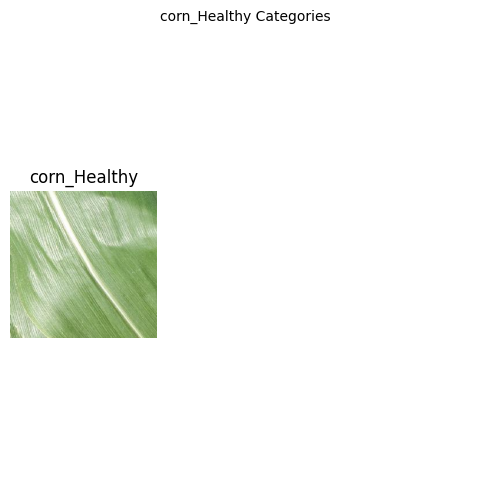

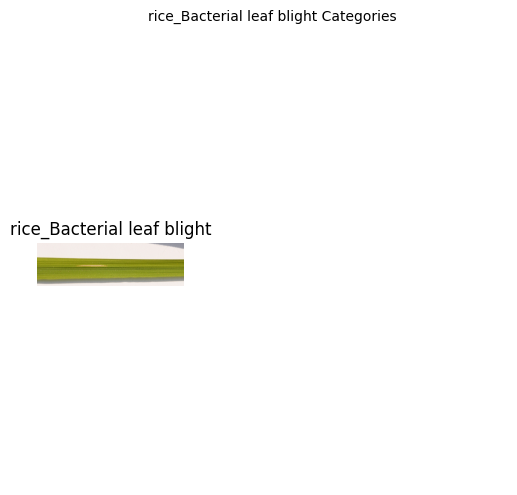

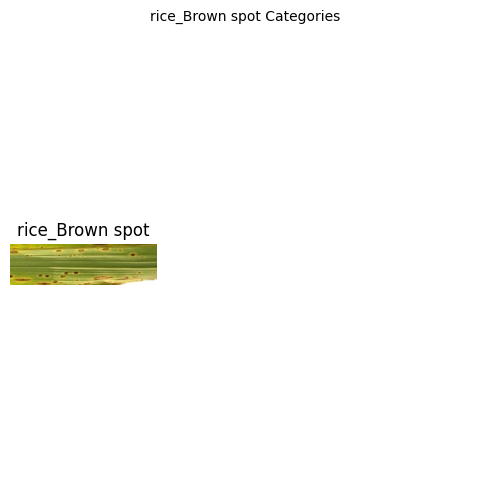

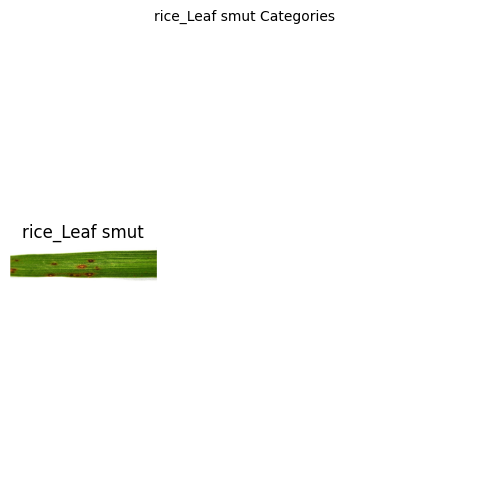

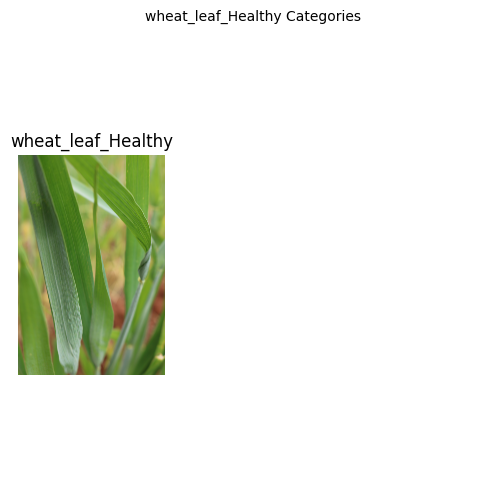

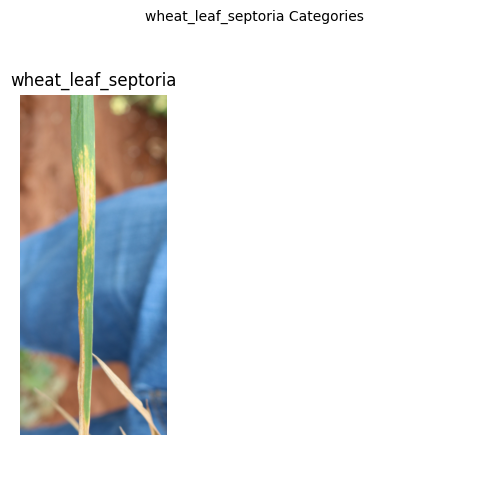

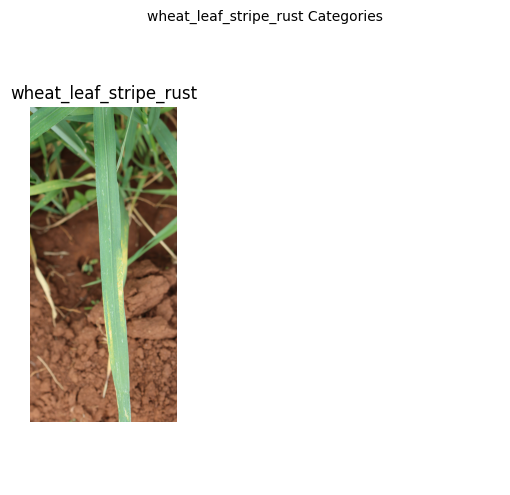

In [11]:
for i in veg_fruite_cat:

    # Define the num columns
    num_cols = 3

    # Calculate the number of rows required
    num_rows = int(np.ceil(veg_fruite_cat[i]/num_cols))

    # Create a figure for the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5 * num_rows))
    axes = axes.flatten()
    fig.suptitle(f'{i} Categories',fontsize=10)
    plt_num = 0
    for j in categories:

        if i in j:
            # Construct the subcategory path
            subcategory_path = os.path.join(train_path, j)

            # Load a sample image from the subcategory
            sample_image = os.listdir(subcategory_path)[0]
            image_path = os.path.join(subcategory_path, sample_image)
            image = cv2.imread(image_path)


            # Convert the image from BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Plot the image
            ax = axes[plt_num]
            ax.imshow(image_rgb)
            ax.set_title(f'{j}')
            ax.axis('off')
            plt_num +=1
    # Hide any unused subplots
    for i in range(plt_num, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [27]:
# with strategy.scope():
# Define the CNN model
input_shape = (256, 256, 3)  # Adjust according to your preprocessed image dimensions
num_classes = 10  # Number of classes in the New Plant Diseases Dataset

model = Sequential()

# Convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# Max Pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(256, activation='relu'))

# Dropout layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 82, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,193,226 (8.37 MB)

 Trainable params: 2,193,226 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
processed_train_dir = 'train/'

# Prepare data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    validation_split=0.2  # Set aside 20% of data for validation
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    processed_train_dir,
    target_size=(256, 256),  # Resize images to match model input
    batch_size=32,
    class_mode='categorical',  # Use categorical labels
    shuffle=True,
    subset='training'  # Explicitly use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    processed_train_dir,
    target_size=(256, 256),  # Resize images to match model input
    batch_size=32,
    class_mode='categorical',  # Use categorical labels
    shuffle=False,
    subset='validation'  # Explicitly use the validation subset
)

Found 3775 images belonging to 10 classes.
Found 940 images belonging to 10 classes.


In [30]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 93s 693ms/step - accuracy: 0.5311 - loss: 1.3405 - precision: 0.7691 - recall: 0.3358 - val_accuracy: 0.7340 - val_loss: 0.7156 - val_precision: 0.9542 - val_recall: 0.5766
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 681ms/step - accuracy: 0.7316 - loss: 0.7626 - precision: 0.8580 - recall: 0.6262 - val_accuracy: 0.7968 - val_loss: 0.4942 - val_precision: 0.8823 - val_recall: 0.7096
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 577ms/step - accuracy: 0.7939 - loss: 0.5501 - precision: 0.8708 - recall: 0.7314 - val_accuracy: 0.8298 - val_loss: 0.4363 - val_precision: 0.8871 - val_recall: 0.7691
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 543ms/step - accuracy: 0.8131 - loss: 0.4923 - precision: 0.8787 - recall: 0.7580 - val_accuracy: 0.8298 - val_loss: 0.4227 - val_precision: 0.8741 - val_recall: 0.7904
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 544ms/step - accuracy: 0.8266 - loss: 0.4564 - precision: 0.8874 - recall: 0.7863 - val_accuracy: 0.8500

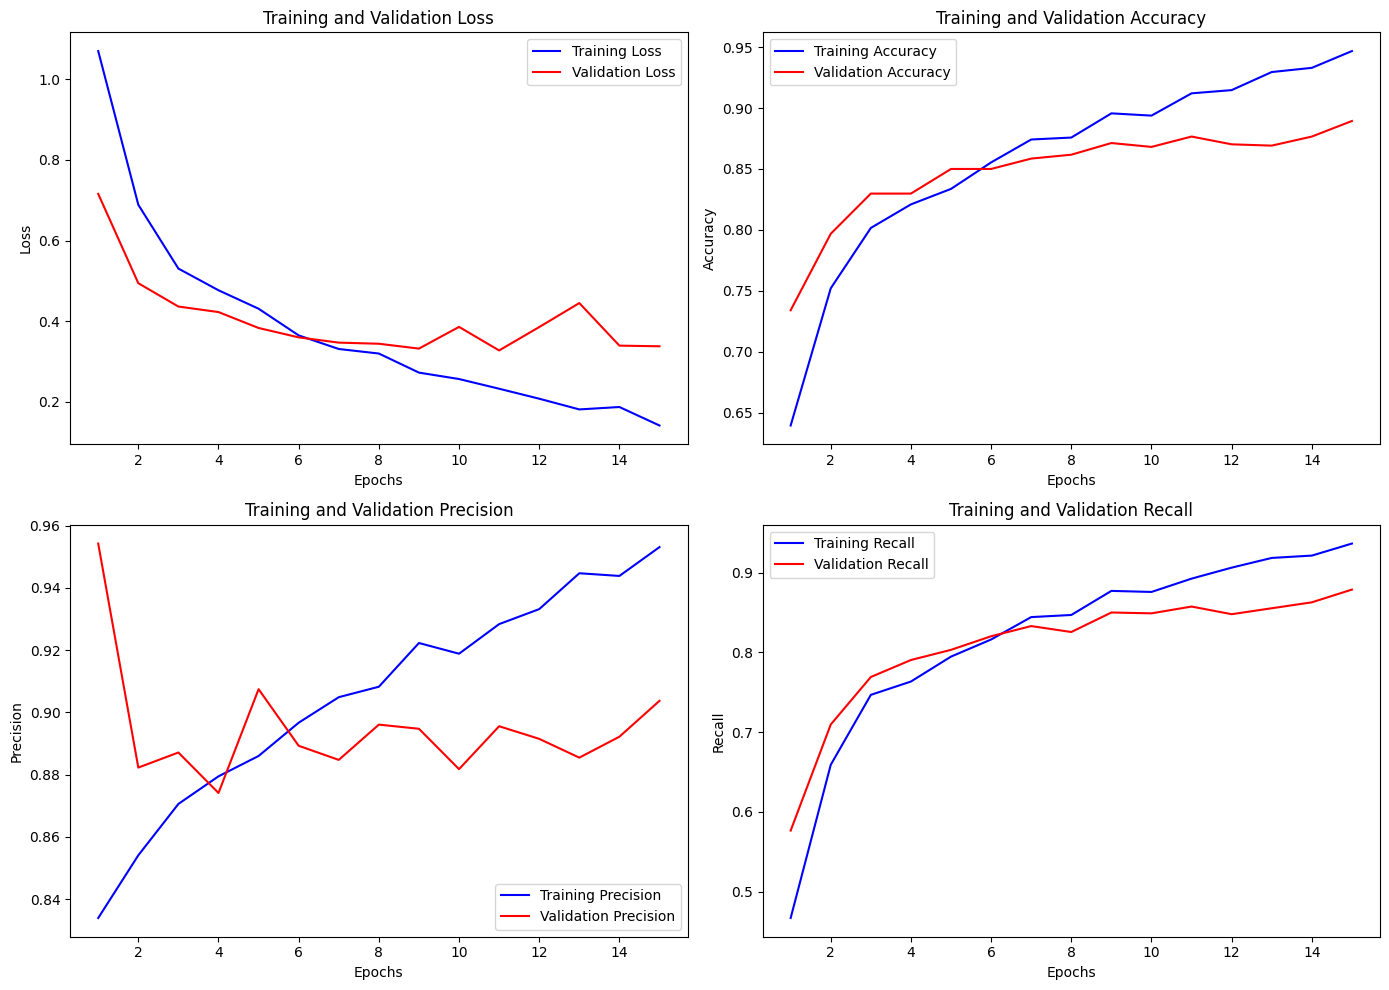

In [31]:
import matplotlib.pyplot as plt

# Extract the metrics from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, precision, 'b', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, recall, 'b', label='Training Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step


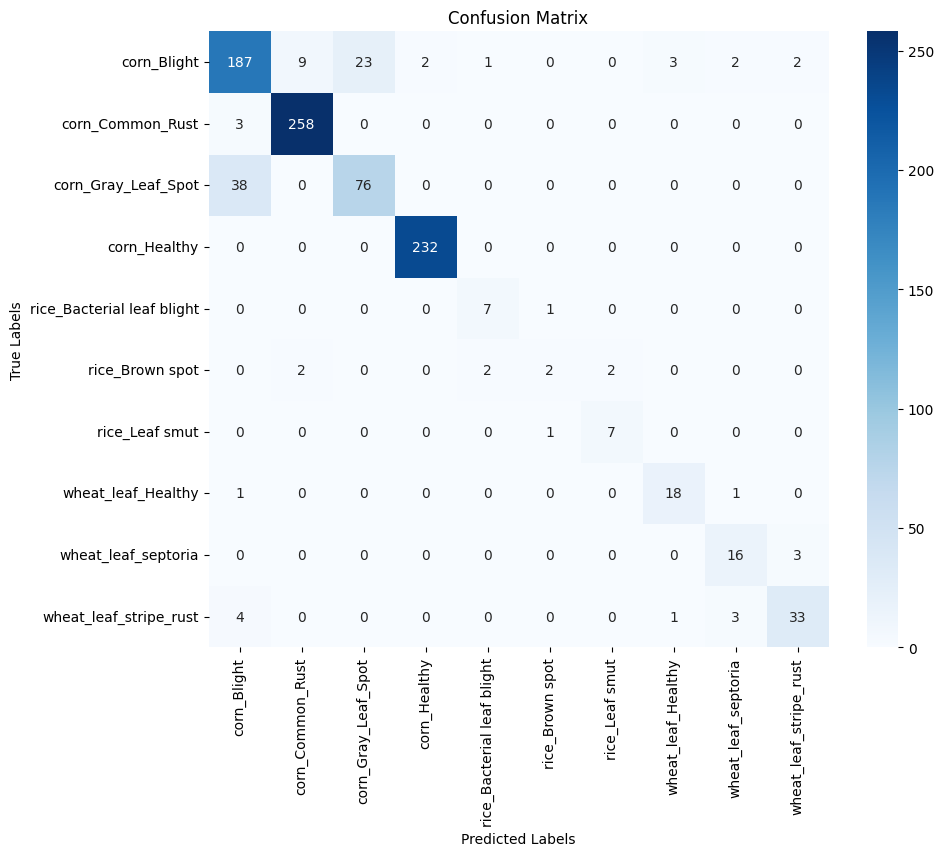

In [32]:
validation_steps = validation_generator.n // validation_generator.batch_size
predictions = model.predict(validation_generator, steps=validation_steps+1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = validation_generator.classes

# Class labels
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
model.save('plant_disease_cnn_model.keras')

In [36]:
# prompt: i want to test the model can u generate code to test it, the image path will be given by me

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('plant_disease_cnn_model.keras')

def predict_disease(image_path):
  img = image.load_img(image_path, target_size=(256, 256))  # Adjust target_size if needed
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0  # Normalize pixel values

  prediction = model.predict(img_array)
  predicted_class_index = np.argmax(prediction)

  # Assuming you have a list of class labels corresponding to the model's output
  class_labels = list(train_generator.class_indices.keys())
  predicted_class = class_labels[predicted_class_index]

  return predicted_class

# Example usage:
image_path = 'train/corn_Common_Rust/Corn_Common_Rust (1006).JPG'  # Replace with the actual path
predicted_disease = predict_disease(image_path)
print(f"Predicted Disease: {predicted_disease}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Predicted Disease: corn_Common_Rust


In [ ]:
# prompt: i want to test the model in a different collab notebook what should i do, i have already downloaded the model , i need the code to test it

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('plant_disease_cnn_model.keras')

def predict_disease(image_path):
  img = image.load_img(image_path, target_size=(256, 256))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction = model.predict(img_array)
  predicted_class_index = np.argmax(prediction)

  # Replace with the actual class labels used during training
  class_labels = ['apple___Apple_scab', 'apple___Black_rot', 'apple___Cedar_apple_rust', 'apple___healthy',
                   'corn___Cercospora_leaf_spot Gray_leaf_spot', 'corn___Common_rust_', 'corn___Northern_Leaf_Blight',
                   'corn___healthy', 'grape___Black_rot', 'grape___Esca_(Black_Measles)', 'grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
                   'grape___healthy']

  predicted_class = class_labels[predicted_class_index]

  return predicted_class

# Example usage:
image_path = 'path/to/your/test/image.jpg'  # Replace with the path to your test image
predicted_disease = predict_disease(image_path)
print(f"Predicted Disease: {predicted_disease}")
